In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'


load dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
TensorFlow version: 2.12.0
KerasNLP version: 0.6.1


In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
print(format(df_train.shape))
print(format(df_test.shape))

(7613, 5)
(3263, 4)


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [11]:
column_name = ['id', 'keyword', 'location', 'text', 'target']
element_count = df_train[column_name].count()
print(element_count)

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64


In [12]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

### PREPROCESSING DATA

In [13]:
BATCH_SIZE = 60
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [14]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

### Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters (paper).

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [15]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

231508/231508 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step   
265570304/265570304 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

### Train your own model, fine-tuning BERT

In [16]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 135s 821ms/step - accuracy: 0.6802 - loss: 0.6049 - val_accuracy: 0.8326 - val_loss: 0.4084
Epoch 2/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 90s 887ms/step - accuracy: 0.8307 - loss: 0.3991 - val_accuracy: 0.8293 - val_loss: 0.3980


In [17]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step


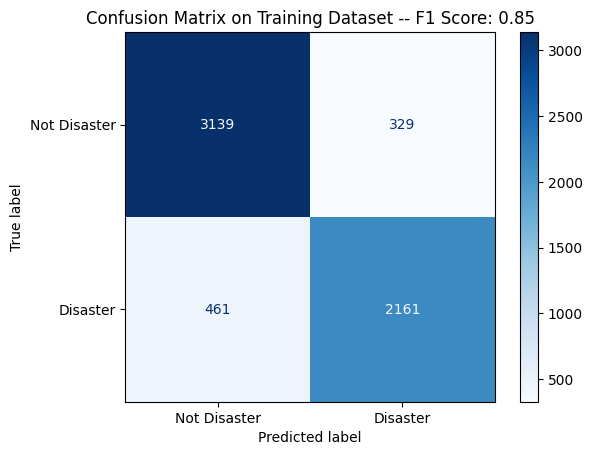

In [18]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step


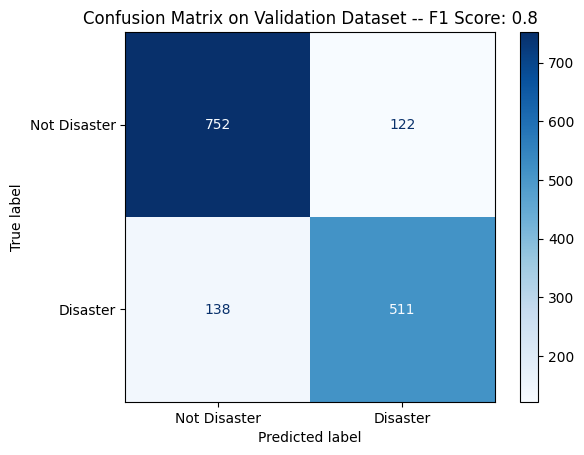

In [19]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [20]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [21]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)


102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step


In [22]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.410052
std,3146.427221,0.491918
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [23]:
sample_submission.to_csv("submission3.csv", index=False)